In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, LinearAxis, Range1d, LabelSet
from bokeh.layouts import column
from bokeh.palettes import Category10
from bokeh.io import output_file
from datetime import datetime
output_notebook()


Loading BokehJS ...

A beadandókban 2017 és 2024 között elemezzük ki a Bitcoin és Ethereum kriptovaluták árfolyammozgásainak pár tulajdonságát.

Először beolvassuk a nyers adatokat egy data framebe.

In [4]:
dfb =pd.read_csv('BTC-USD (2014-2024).csv')
dfe =pd.read_csv('ETH-USD (2017-2024).csv')
dfb.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
1,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
2,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
3,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0
4,2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600.0


In [6]:
dfb['Date'] = pd.to_datetime(dfb['Date'])
dfe['Date'] = pd.to_datetime(dfe['Date'])

dfb.set_index('Date', inplace=True)
dfe.set_index('Date', inplace=True)

Indexként megjelöltük a dátumot. Ezután megtisztítjuk az adatokat, először megnézzük, létezik a null érték.

In [8]:
print(dfb.isna().sum())
print(dfe.isna().sum())    

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64


Ebből arra következtetnénk, hogy létezik egy nap, melyről az adatok hiányoznak, de lehet több oszlopot és napot érint. Vizsgáljuk meg.

In [10]:
print(dfb[dfb.isnull().any(axis=1)])
print(dfe[dfe.isnull().any(axis=1)])

            Open  High  Low  Close  Adj Close  Volume
Date                                                 
2024-01-20   NaN   NaN  NaN    NaN        NaN     NaN
            Open  High  Low  Close  Adj Close  Volume
Date                                                 
2024-01-20   NaN   NaN  NaN    NaN        NaN     NaN


Ahogy látjuk, 2024.01.20. dátumról hiányoznak az adatok. Ezt eltávolítjuk az adatokból

In [12]:
dfb = dfb.dropna(subset=['Adj Close'])
dfe = dfe.dropna(subset=['Adj Close'])

Következőleg a Bitcoin és Ethereum adatainkat egyesítsük egy data framebe. Azért, hogy ne legyenek azonosan elnevezett oszlopok, először hozzárakunk egy előtagot.

In [14]:
dfb = dfb.rename(columns=lambda x: 'BTC_' + x if x != 'Date' else x)
dfe = dfe.rename(columns=lambda x: 'ETH_' + x if x != 'Date' else x)
dfb.head()

,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Adj Close,BTC_Volume
Date,,,,,,
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0
2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600.0


In [15]:
df = dfb.join(dfe, how='inner')
df.head()

,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Adj Close,BTC_Volume,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Adj Close,ETH_Volume
Date,,,,,,,,,,,,
2017-11-10,7173.729980,7312.000000,6436.870117,6618.140137,6618.140137,5.208250e+09,320.670990,324.717987,294.541992,299.252991,299.252991,8.859860e+08
2017-11-11,6618.609863,6873.149902,6204.220215,6357.600098,6357.600098,4.908680e+09,298.585999,319.453003,298.191986,314.681000,314.681000,8.423010e+08
2017-11-12,6295.450195,6625.049805,5519.009766,5950.069824,5950.069824,8.957350e+09,314.690002,319.153015,298.513000,307.907990,307.907990,1.613480e+09
2017-11-13,5938.250000,6811.189941,5844.290039,6559.490234,6559.490234,6.263250e+09,307.024994,328.415009,307.024994,316.716003,316.716003,1.041890e+09
2017-11-14,6561.479980,6764.979980,6461.750000,6635.750000,6635.750000,3.197110e+09,316.763000,340.177002,316.763000,337.631012,337.631012,1.069680e+09


Inner joint használunk, így leszűrjük az adatokat azokra a dátumokra, melyeken mindkét valutáról van adatunk.

In [17]:
print(df['BTC_Close'].sum()-df['BTC_Adj Close'].sum())
print(df['ETH_Close'].sum()-df['ETH_Adj Close'].sum())

0.0
0.0


In [18]:

source = ColumnDataSource(df)

p = figure(title="ETH vs BTC Close Prices", x_axis_type='datetime',
           width=800, height=400, tools="pan,wheel_zoom,box_zoom,reset,save")

p.line(x='Date', y='ETH_Close', source=source, legend_label="ETH", line_width=2, color="blue")
p.line(x='Date', y='BTC_Close', source=source, legend_label="BTC", line_width=2, color="orange")

hover = HoverTool(
    tooltips=[("Date", "@Date{%F}"),
              ("ETH", "@ETH_Close{$0,0.00}"),
              ("BTC", "@BTC_Close{$0,0.00}")],
    formatters={'@Date': 'datetime'},
    mode='vline'
)
p.add_tools(hover)

p.legend.location = "top_left"
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Price (USD)'

show(p)



Látszódik, hogy van valamilyen közös mozgás a kettő valuta között, viszont a bitcoin ára magasabb, mint az ethereumé. Nézzük meg, átlagosan mekkora mértékbeli különbség van köztük.

In [20]:
print(df['BTC_Close'].sum()/df['ETH_Close'].sum())

17.40391418021228


Szorozzuk meg ezzel az értékkel az ethereumét, így könnyebben látható a közös mozgásuk.

In [22]:
df['ETH_Close17'] = df['ETH_Close']*17
source = ColumnDataSource(df)

p = figure(title="ETH vs BTC Close Prices", x_axis_type='datetime',
           width=800, height=400, tools="pan,wheel_zoom,box_zoom,reset,save")

p.line(x='Date', y='ETH_Close17', source=source, legend_label="ETH*17", line_width=2, color="blue")
p.line(x='Date', y='BTC_Close', source=source, legend_label="BTC", line_width=2, color="orange")

hover = HoverTool(
    tooltips=[("Date", "@Date{%F}"),
              ("ETH*17", "@ETH_Close*17{$0,0.00}"),
              ("BTC", "@BTC_Close{$0,0.00}")],
    formatters={'@Date': 'datetime'},
    mode='vline'
)
p.add_tools(hover)

p.legend.location = "top_left"
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Price (USD)'

show(p)


Először vizsgáljuk meg a zárási árakból számított napi hozamokat

In [24]:
df['BTC_Return'] = dfb['BTC_Close'].pct_change()
df['ETH_Return'] = dfe['ETH_Close'].pct_change()
source = ColumnDataSource(df)
p = figure(title="ETH vs BTC Daily Returns", x_axis_type='datetime',
           width=800, height=400, tools="pan,wheel_zoom,box_zoom,reset,save")

p.line(x='Date', y='ETH_Return', source=source, legend_label="ETH", line_width=2, color="blue")
p.line(x='Date', y='BTC_Return', source=source, legend_label="BTC", line_width=2, color="orange")

hover = HoverTool(
    tooltips=[("Date", "@Date{%F}"),
              ("ETH", "@ETH_Return{0.00%}"),
              ("BTC", "@BTC_Return{0.00%}")],
    formatters={'@Date': 'datetime'},
    mode='vline'
)
p.add_tools(hover)

p.legend.location = "top_left"
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Return (%)'

show(p)

Ebből elkészíthetjük a 30 napos volatilitási mérőszámot, mely az áringadozások mértékének mérőszáma.

In [26]:
df['BTC_Volatility'] = df['BTC_Return'].rolling(window=30).std()
df['ETH_Volatility'] = df['ETH_Return'].rolling(window=30).std()

source = ColumnDataSource(df)

p = figure(title="BTC vs ETH 30-Day Rolling Volatility", x_axis_type='datetime',
           width=800, height=400, tools="pan,wheel_zoom,box_zoom,reset,save")

p.line(x='Date', y='ETH_Volatility', source=source, legend_label="ETH", line_width=2, color="blue")
p.line(x='Date', y='BTC_Volatility', source=source, legend_label="BTC", line_width=2, color="orange")

hover = HoverTool(
    tooltips=[("Date", "@Date{%F}"),
              ("ETH", "@ETH_Volatility{0.00%}"),
              ("BTC", "@BTC_Volatility{0.00%}")],
    formatters={'@Date': 'datetime'},
    mode='vline'
)
p.add_tools(hover)

p.legend.location = "top_left"
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Volatility (%)'

show(p)

Vizsgáljuk meg a napi volatilitást is a min és max segítségével

In [28]:
df['BTC_Daily Volatility'] = (df['BTC_High'] - df['BTC_Low']) / df['BTC_Open'] * 100
df['ETH_Daily Volatility'] = (df['ETH_High'] - df['ETH_Low']) / df['ETH_Open'] * 100

source = ColumnDataSource(df)

p = figure(title="BTC vs ETH Daily Volatility", x_axis_type='datetime',
           width=800, height=400, tools="pan,wheel_zoom,box_zoom,reset,save")

p.line(x='Date', y='ETH_Daily Volatility', source=source, legend_label="ETH", line_width=2, color="blue")
p.line(x='Date', y='BTC_Daily Volatility', source=source, legend_label="BTC", line_width=2, color="orange")

hover = HoverTool(
    tooltips=[("Date", "@Date{%F}"),
              ("ETH", "@ETH_Daily Volatility{0.00%}"),
              ("BTC", "@BTC_Daily Volatility{0.00%}")],
    formatters={'@Date': 'datetime'},
    mode='vline'
)
p.add_tools(hover)

p.legend.location = "top_left"
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Volatility (%)'

show(p)

Megnézzük, hogy esetlegesen van-e kapcsolat a kereskedés mennyisége és a valuta ára között, először ábrázoljuk grafikonon.

In [30]:
p = figure(title="BTC Price vs Volume", x_axis_type="datetime", width=800, height=400,
           y_axis_label="Price (USD)", tools="pan,wheel_zoom,box_zoom,reset,save")
p.extra_y_ranges = {"volume": Range1d(start=df["BTC_Volume"].min(), end=df["BTC_Volume"].max()), "price": Range1d(start=df["BTC_Adj Close"].min(), end=df["BTC_Adj Close"].max()) }
p.line(x='Date', y='BTC_Adj Close', source=source, y_range_name="price", color="orange", legend_label="BTC Price", line_width=2)

p.add_layout(LinearAxis(y_range_name="volume", axis_label="Volume"), 'right')

p.line(x='Date', y='BTC_Volume', source=source, y_range_name="volume",
       color="red", legend_label="BTC Volume", line_width=2)


hover = HoverTool(tooltips=[
    ("Date", "@Date{%F}"),
    ("Price", "@{BTC_Adj Close}{$0,0.00}"),
    ("Volume", "@BTC_Volume{0,0}")
], formatters={'@Date': 'datetime'}, mode='vline')
p.add_tools(hover)

p.legend.location = "top_left"


show(p)

Nézzük meg az Ethereummal is.

In [32]:
p = figure(title="ETH Price vs Volume", x_axis_type="datetime", width=800, height=400,
           y_axis_label="Price (USD)", tools="pan,wheel_zoom,box_zoom,reset,save")
p.extra_y_ranges = {"volume": Range1d(start=df["ETH_Volume"].min(), end=df["ETH_Volume"].max()), "price": Range1d(start=df["ETH_Adj Close"].min(), end=df["ETH_Adj Close"].max()) }
p.line(x='Date', y='ETH_Adj Close', source=source, y_range_name="price", color="blue", legend_label="ETH Price", line_width=2)

p.add_layout(LinearAxis(y_range_name="volume", axis_label="Volume"), 'right')

p.line(x='Date', y='ETH_Volume', source=source, y_range_name="volume",
       color="green", legend_label="ETH Volume", line_width=2)


hover = HoverTool(tooltips=[
    ("Date", "@Date{%F}"),
    ("Price", "@{ETH_Adj Close}{$0,0.00}"),
    ("Volume", "@ETH_Volume{0,0}")
], formatters={'@Date': 'datetime'}, mode='vline')
p.add_tools(hover)

p.legend.location = "top_left"


show(p)

Látni vélünk valamely együttmozgást, de kisebb mértékben, mint mondjuk a két valuta árértékében. Vizsgáljuk meg a korrelációt konkrét számadatokkal.

In [34]:
correlation = df[['BTC_Close', 'BTC_Volume']].corr().iloc[0, 1]
print(f"BTC Price-Volume Correlation: {correlation:.2f}")

BTC Price-Volume Correlation: 0.49


Mérsékelt pozitív korrelációt találtunk. Nézzük meg egy scatterploton is.

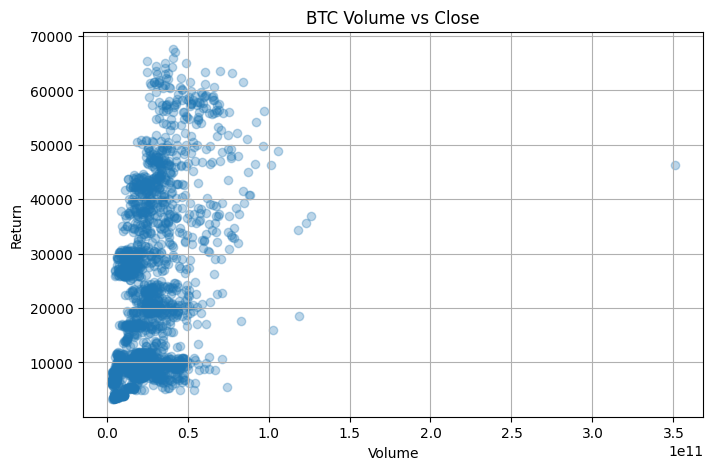

In [36]:
plt.figure(figsize=(8, 5))
plt.scatter(df['BTC_Volume'], df['BTC_Close'], alpha=0.3)
plt.title('BTC Volume vs Close')
plt.xlabel('Volume')
plt.ylabel('Return')
plt.grid(True)
plt.show()

Látszódik, hogy létezik pár kiugró érték.

In [38]:
correlation = df[['ETH_Adj Close', 'ETH_Volume']].corr().iloc[0, 1]
print(f"ETH Price-Volume Correlation: {correlation:.2f}")

ETH Price-Volume Correlation: 0.47


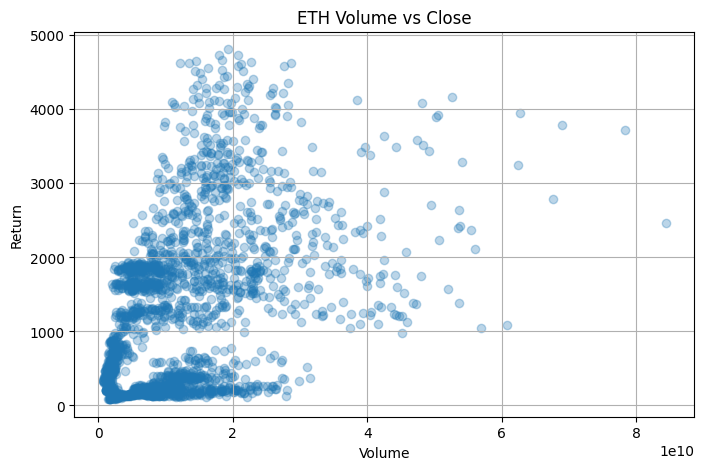

In [39]:
plt.figure(figsize=(8, 5))
plt.scatter(df['ETH_Volume'], df['ETH_Adj Close'], alpha=0.3)
plt.title('ETH Volume vs Close')
plt.xlabel('Volume')
plt.ylabel('Return')
plt.grid(True)
plt.show()

In [40]:
correlation = df[['ETH_Adj Close', 'BTC_Adj Close']].corr().iloc[0, 1]
print(f"ETH Price-BTC Price Correlation: {correlation:.2f}")

ETH Price-BTC Price Correlation: 0.92


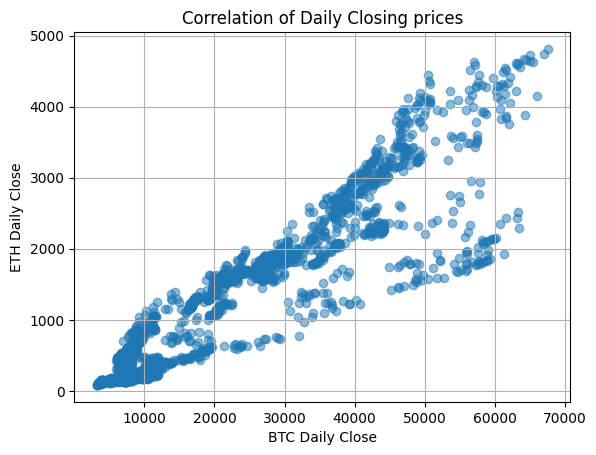

In [41]:
plt.scatter(df['BTC_Close'], df['ETH_Close'], alpha=0.5)
plt.xlabel('BTC Daily Close')
plt.ylabel('ETH Daily Close')
plt.title('Correlation of Daily Closing prices')
plt.grid(True)
plt.show()

In [42]:
correlation = df[['ETH_Return', 'BTC_Return']].corr().iloc[0, 1]
print(f"ETH Price-BTC Price Correlation: {correlation:.2f}")

ETH Price-BTC Price Correlation: 0.77


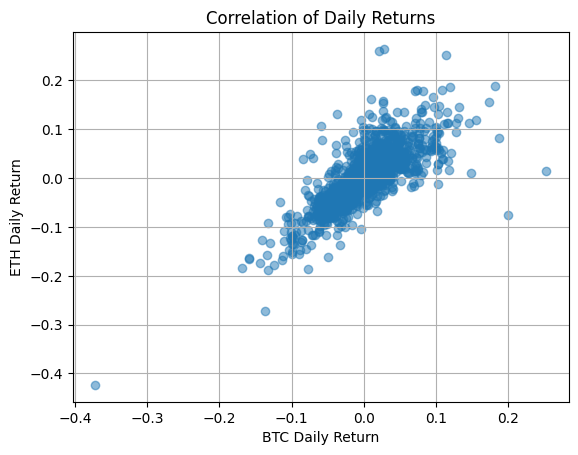

In [43]:
plt.scatter(df['BTC_Return'], df['ETH_Return'], alpha=0.5)
plt.xlabel('BTC Daily Return')
plt.ylabel('ETH Daily Return')
plt.title('Correlation of Daily Returns')
plt.grid(True)
plt.show()

In [44]:
df['BTC_Abs_Return'] = df['BTC_Return'].abs()
df['ETH_Abs_Return'] = df['ETH_Return'].abs()

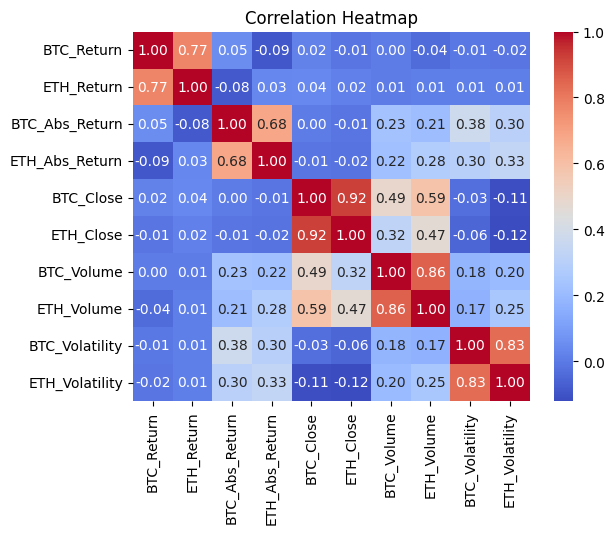

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[['BTC_Return', 'ETH_Return','BTC_Abs_Return', 'ETH_Abs_Return' ,'BTC_Close', 'ETH_Close', 'BTC_Volume', 'ETH_Volume', 'BTC_Volatility', 'ETH_Volatility']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Következőleg megvizsgáljuk a kereszt korrelációkat, melynek lényege az, hogy megtudjuk, egyik valuta áringadozása megelőzi-e az egyiket.

In [47]:
from statsmodels.tsa.stattools import ccf

btc_returns = df['BTC_Return'].dropna()
eth_returns = df['ETH_Return'].dropna()

min_len = min(len(btc_returns), len(eth_returns))
btc_returns = btc_returns[-min_len:]
eth_returns = eth_returns[-min_len:]

lags = 30
ccf_vals = ccf(btc_returns, eth_returns)[:lags]

x = list(range(lags))
y = ccf_vals

source = ColumnDataSource(data=dict(x=x, y=y))

p = figure(width=800, height=400, title="Cross-Correlation: BTC leads ETH")
p.line('x', 'y', source=source, line_width=2, line_color="blue")

p.xaxis.axis_label = "Lag (days)"
p.yaxis.axis_label = "Correlation"
p.grid.grid_line_color = "gray"
p.add_layout(p.title, 'above')

# Show the plot
output_notebook()
show(p)

Loading BokehJS ...

Ahogy láthatjuk, erős korrelációt csak a 0. napra figyeltünk meg. Ebből az szűrhető le, hogy a Bitcoin és Ethereum árak ugyanazon a napon erősen együtt mozognak, egyik se mutat napos lemaradást. Felvetődik a kérdés, hogy ha esetleg órákra lebontott adatokkal dolgoznánk, figyelhető lenne-e keresztkorreláció.

Következőleg megpróbálunk egy machine learning modellt készíteni. Feladatunk az lesz, hogy az aznapi mutatók, és árváltozások alapján megjósoljuk, hogy a következő napon a hozam pozitív, illetve negatív lesz. A kriptovaluták eléggé volatilis befektetések, eddig a legfejlettebb gépi tanulási modellek is csak kis mértékben jobbak a véletlenszerű találgatásnál.

In [50]:
dfml = df[df[['BTC_Return','ETH_Return']].notna().all(axis=1)].copy()

In [51]:
dfml = dfml.drop(['BTC_Volatility', 'ETH_Volatility', 'BTC_Daily Volatility', 'ETH_Daily Volatility'], axis = 1)
print(dfml.isna().sum())         


BTC_Open          0
BTC_High          0
BTC_Low           0
BTC_Close         0
BTC_Adj Close     0
BTC_Volume        0
ETH_Open          0
ETH_High          0
ETH_Low           0
ETH_Close         0
ETH_Adj Close     0
ETH_Volume        0
ETH_Close17       0
BTC_Return        0
ETH_Return        0
BTC_Abs_Return    0
ETH_Abs_Return    0
dtype: int64


In [52]:
#Machine Learning(kriptóra nehezen alkalmazható)

dfml['BTC_Target'] = (dfml['BTC_Return'].shift(-1) > 0).astype(int)
dfml['ETH_Target'] = (dfml['ETH_Return'].shift(-1) > 0).astype(int)
dfml.dropna(subset=['BTC_Return', 'ETH_Return', 'BTC_Target', 'ETH_Target'], inplace=True)
dfml.tail()
print(dfml.isna().sum())     

BTC_Open          0
BTC_High          0
BTC_Low           0
BTC_Close         0
BTC_Adj Close     0
BTC_Volume        0
ETH_Open          0
ETH_High          0
ETH_Low           0
ETH_Close         0
ETH_Adj Close     0
ETH_Volume        0
ETH_Close17       0
BTC_Return        0
ETH_Return        0
BTC_Abs_Return    0
ETH_Abs_Return    0
BTC_Target        0
ETH_Target        0
dtype: int64


In [53]:
from sklearn.model_selection import train_test_split
X = dfml.drop(columns=['ETH_Open','ETH_High','ETH_Low','ETH_Close','ETH_Adj Close','ETH_Volume', 'ETH_Target', 'ETH_Return', 'BTC_Target', 'BTC_Adj Close'])
y = dfml['BTC_Target']


In [54]:
X.head()

,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,ETH_Close17,BTC_Return,BTC_Abs_Return,ETH_Abs_Return
Date,,,,,,,,,
2017-11-11,6618.609863,6873.149902,6204.220215,6357.600098,4.908680e+09,5349.577000,-0.039368,0.039368,0.051555
2017-11-12,6295.450195,6625.049805,5519.009766,5950.069824,8.957350e+09,5234.435830,-0.064101,0.064101,0.021523
2017-11-13,5938.250000,6811.189941,5844.290039,6559.490234,6.263250e+09,5384.172051,0.102422,0.102422,0.028606
2017-11-14,6561.479980,6764.979980,6461.750000,6635.750000,3.197110e+09,5739.727204,0.011626,0.011626,0.066037
2017-11-15,6634.759766,7342.250000,6634.759766,7315.540039,4.200880e+09,5667.068915,0.102444,0.102444,0.012659


In [55]:
print(y)

Date
2017-11-11    0
2017-11-12    1
2017-11-13    1
2017-11-14    1
2017-11-15    1
             ..
2024-01-16    0
2024-01-17    0
2024-01-18    1
2024-01-19    1
2024-01-21    0
Name: BTC_Target, Length: 2262, dtype: int32


In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=1, min_samples_split=3)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.45      0.48       332
           1       0.53      0.59      0.56       347

    accuracy                           0.52       679
   macro avg       0.52      0.52      0.52       679
weighted avg       0.52      0.52      0.52       679



In [58]:
y_random = np.random.randint(0, 2, size=y_test.shape)
print(classification_report(y_test, y_random))

              precision    recall  f1-score   support

           0       0.51      0.48      0.50       332
           1       0.53      0.55      0.54       347

    accuracy                           0.52       679
   macro avg       0.52      0.52      0.52       679
weighted avg       0.52      0.52      0.52       679



Következőleg megvizsgálnánk, melyikek voltak az árfolyamok legvolatilisebb napjai, és megvizsgáljuk, hogy ezek miért történhettek.

In [60]:
top5btc = df['BTC_Daily Volatility'].nlargest(5)
print(top5btc)

Date
2020-03-12    38.778254
2020-03-13    34.499643
2021-05-19    29.956056
2017-12-07    26.933777
2018-01-16    26.367252
Name: BTC_Daily Volatility, dtype: float64


In [61]:
top5eth = df['ETH_Daily Volatility'].nlargest(5)
print(top5eth)

Date
2021-05-19    43.914458
2020-03-12    43.102439
2020-03-13    37.488006
2017-12-22    34.513265
2021-05-20    33.731071
Name: ETH_Daily Volatility, dtype: float64


In [62]:
top = top5btc.index.intersection(top5eth.index)
print(top)

DatetimeIndex(['2020-03-12', '2020-03-13', '2021-05-19'], dtype='datetime64[ns]', name='Date', freq=None)


Összenéztük a dátumok metszetét, három napot emeltünk ki. Ebből 2 nap egymást követi, most utánanézünk, hogy mi lehetett az ok ezen áringadozások mögött.

In [64]:
print(df.loc['2021-05-19'])

BTC_Open                4.294498e+04
BTC_High                4.354612e+04
BTC_Low                 3.068150e+04
BTC_Close               3.700244e+04
BTC_Adj Close           3.700244e+04
BTC_Volume              1.263581e+11
ETH_Open                3.382657e+03
ETH_High                3.437936e+03
ETH_Low                 1.952460e+03
ETH_Close               2.460679e+03
ETH_Adj Close           2.460679e+03
ETH_Volume              8.448291e+10
ETH_Close17             4.183155e+04
BTC_Return             -1.376612e-01
ETH_Return             -2.720035e-01
BTC_Volatility          5.154253e-02
ETH_Volatility          8.162272e-02
BTC_Daily Volatility    2.995606e+01
ETH_Daily Volatility    4.391446e+01
BTC_Abs_Return          1.376612e-01
ETH_Abs_Return          2.720035e-01
Name: 2021-05-19 00:00:00, dtype: float64


Ezen a napon a Bitcoin és Ethereum ára drasztikus visszaesésen ment keresztül. Ennek több fontos oka volt. Egyrészt a kínai kormány erős korlátozásokat vezetett be a kriptopiacra, illetve Elon Musk bejelentette, hogy a Tesla felfüggeszti a bitcointranzakciókat. Ezek a döntések egy eladási hullámot hoztak létre, mely árcsökkenéssel járult. A nap folyamán ez az eladási hullám egyre erősebb lett, több kriptokereskedő felületen emiatt hibák és lezárások következtek be, és ez tovább fokozta a pánikot.

In [66]:
print(df.loc[['2020-03-12','2020-03-13']])

               BTC_Open     BTC_High      BTC_Low    BTC_Close  BTC_Adj Close  \
Date                                                                            
2020-03-12  7913.616211  7929.116211  4860.354004  4970.788086    4970.788086   
2020-03-13  5017.831055  5838.114746  4106.980957  5563.707031    5563.707031   

              BTC_Volume    ETH_Open    ETH_High     ETH_Low   ETH_Close  ...  \
Date                                                                      ...   
2020-03-12  5.398036e+10  194.738922  195.147934  111.210709  112.347122  ...   
2020-03-13  7.415677e+10  112.689995  137.429535   95.184303  133.201813  ...   

              ETH_Volume  ETH_Close17  BTC_Return  ETH_Return  BTC_Volatility  \
Date                                                                            
2020-03-12  2.213474e+10  1909.901074   -0.371695   -0.423472        0.072125   
2020-03-13  2.786462e+10  2264.430821    0.119281    0.185627        0.076333   

            ETH_Volatilit

Ez a két nap egy szélesebb globális trend részei voltak. 12-e volt az úgynevezett 'fekete csütörtök', melyen az egész globális piac az éppen kifejlődő világjárvány miatt összeesett. Ez az összeesés nem kerülte el a kriptoárfolyamokat sem, ezen a napon drasztikus csökkenés volt megfigyelhető. A következő napon tovább folytatódott az esés, majd a nap végére növekedés volt megfigyelhető.

Ezt szemléltessük egy ábrán:

In [115]:
df['ETH_Close17'] = df['ETH_Close']*17

highlight_dates = [datetime(2020, 3, 12), datetime(2021, 5, 19), datetime(2020, 12 , 1), datetime(2021, 11 , 10), datetime(2022, 1 , 1)]
highlight_labels = ["Covid által okozott összeesés", "Intézményi támogatás, infláció elkerülése", "Kína, Tesla korlátozásokat jelent be", "Történelmi csúcs", "Buborék kipukkan"]

highlight_df = df[df.index.isin(highlight_dates)].copy()

highlight_df['Event_Label'] = highlight_labels

source = ColumnDataSource(df)
highlight_source = ColumnDataSource(highlight_df)

p = figure(title="ETH vs BTC Close Prices", x_axis_type='datetime',
           width=800, height=400, tools="pan,wheel_zoom,box_zoom,reset,save")

p.line(x='Date', y='ETH_Close17', source=source, legend_label="ETH*17", line_width=2, color="blue")
p.line(x='Date', y='BTC_Close', source=source, legend_label="BTC", line_width=2, color="orange")

p.scatter(x='Date', y='BTC_Close', source=highlight_source, size=10, color='black', legend_label="Events")

hover = HoverTool(
    tooltips=[("Date", "@Date{%F}"),
              ("ETH*17", "@ETH_Close*17{$0,0.00}"),
              ("BTC", "@BTC_Close{$0,0.00}")],
    formatters={'@Date': 'datetime'},
    mode='vline'
)
p.add_tools(hover)

labels = LabelSet(x='Date', y='BTC_Close', text='Event_Label',  # Reference the new column here
                  level='glyph', x_offset=5, y_offset=5, source=highlight_source, 
                  text_font_size="10pt", text_color="black")

p.add_layout(labels)

p.legend.location = "top_left"
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Price (USD)'

show(p)